<a href="https://colab.research.google.com/github/lilphonsdale/baseball/blob/main/PhilFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Old people can still barrel the ball in 2020?**
## An exploratory data anlysis with Python

Before I explain the title of this notebook, let me start from the very beginning. I grew up reading box scores and the backs of baseball cards. I would pore over stastistics; won-loss records, batting averages, so-called "magic numbers" to clinch playoff spots. Despite the fact that early standardized test scores convinced me I was simply not a "math person", that I had no quantativative bone in my body, my love of baseball has always kept me in conversation with spreadsheets and statistics. When I signed up for this class, I immediately thought of looking at baseball data.

Baseball has changed since I used to check the standings in the newspaper every morning. The Major Leagues have undergone an analytics revolution, turning away from the intuition that used to drive managers and scouts and toward data that optimizes decision quality (if not outcome quality - just ask my beloved Oakland A's). 

There's more data available than ever. Today's ballparks are outfitted with sophisticated networks of sensors that measure the spin rate of pitches, the launch angle of home runs, the speed of a runner as he stretches a single into a double. Best of all, this data is publicly accessible - anyone can go to https://baseballsavant.mlb.com/ and create their own custom data set. 

I was a bit stuck at the outset of this project, not sure how to direct my analysis, so I turned to a friend, actually an old baseball teammate for advice. I asked him to pull a data set from the baseball savant site and sent it over, along with a question whose answer could only be buried somewhere deep within. His response:

---


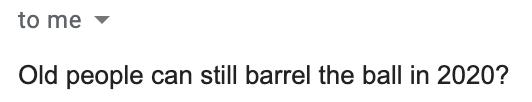


---


What that means in American English is, "Can older players still hit the ball well?" The following analysis is my attempt to apply the lessons learned in CS 65 to formulating a response. 

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import missingno as mn
import numpy as np
import pydotplus
from scipy.cluster import hierarchy
import seaborn as sns
from sklearn import decomposition, preprocessing, cluster, tree
from yellowbrick.cluster.silhouette import SilhouetteVisualizer

df = pd.read_csv('/content/drive/My Drive/Python Data Analysis/masterstats.csv')
df.columns = df.columns.str.lstrip()
bb = df.drop(columns='Unnamed: 51')
bb

### Wow, that's a lot of data!
Where to begin?! Well, to start, let's look at the 'player_age' column a bit, to understand what constitutes 'old people' in this context. 

In [ ]:
bb.player_age.describe()

count    4127.000000
mean       28.332203
std         3.817249
min        20.000000
25%        25.000000
50%        28.000000
75%        31.000000
max        45.000000
Name: player_age, dtype: float64

We can see that the average age was 28, and that most players are within 4 years of that. We also have an example of an outlier, with at least one player at 45 years old. Let's say that for our purposes, 'old people' are in the 95th percentile of 'player_age':

In [ ]:
bb.player_age.quantile(.95)

35.0

Now, on to "barreling the ball". Barreling the ball simply means making solid contact, but like everything else in today's game, it is now being quantified. Sensors in the stadiums measure the speed at which the ball leaves the bat - we have this in the 'exit_velocity_avg' column, along with the angle at which the ball leaves the bat ('launch_angle_avg') and these are actually combined in something called 'barrel_batted_rate'. Let's look at each of these by player age. 

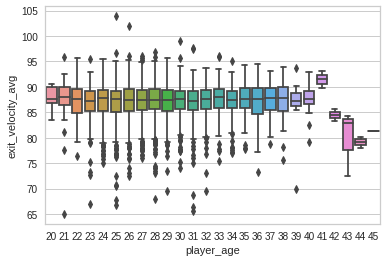

In [ ]:
sns.boxplot(x='player_age',y='exit_velocity_avg',data=bb)

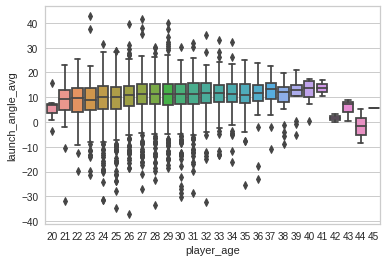

In [ ]:
sns.boxplot(x='player_age',y='launch_angle_avg',data=bb)

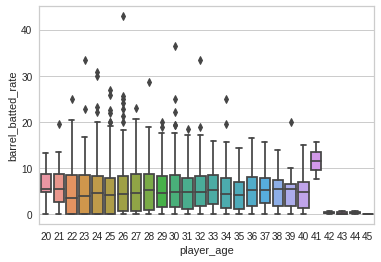

In [ ]:
sns.boxplot(x='player_age',y='barrel_batted_rate',data=bb)

My initial reaction to these is that from age 35-41, 'old people can still barrel ball' while from age 41+ it seems that the few players who do make it that far are clearly past their peak performance. Let's have a look at how 'player_age' correlates to the rest of our data to see if that gives us some insights into how performance is affected by aging.

In [ ]:
old = pd.DataFrame(bb.corr().loc['player_age'])
old.drop('player_age').sort_values('player_age').style.background_gradient(cmap='RdBu')

,player_age
z_swing_miss_percent,-0.123666
oz_swing_miss_percent,-0.099927
poorlytopped_percent,-0.090015
b_triple,-0.070222
opposite_percent,-0.070181
f_strike_percent,-0.062245
r_total_stolen_base,-0.061343
r_total_caught_stealing,-0.060725
swing_percent,-0.056163
oz_swing_percent,-0.054329


There are a few things that I find really interesting in this - evidence that as they get older, players swing and miss at pitches in the strike zone less, and find themselves hitting into double plays more. However, it doesn't seem like any of these correlations is very strong at all - as the range is only from about -0.15 to 0.15:

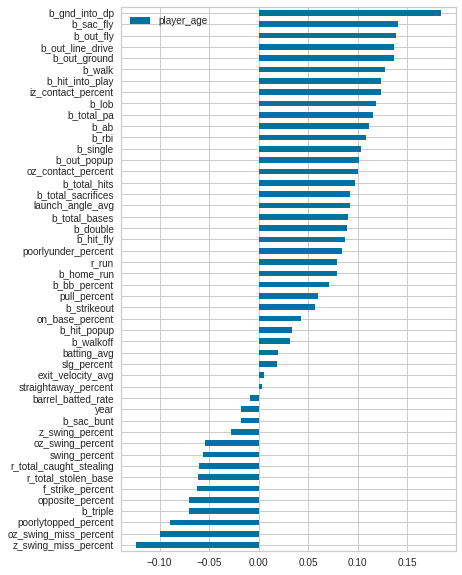

In [ ]:
old.drop('player_age').sort_values('player_age').plot.barh(figsize=(6,10))

What does this tell us about the effects of againg on player performance? What I take away from this initial exploratory data analysis is that players who manage to stay in the Major Leagues long enough to reach the 95% percentile of age are consistent, high-level performers - basically the answer to my friend's question would be yes, old people can still barrel the ball, because only old people who can still barrel the ball are given the opportunity to do so.

#Someday MLB will stand for Machine Learning Baseball
## Going further with Principal Component Analysis and Clustering

What can we learn from this data when we let it tell its own story? Let's find out, and then circle back to see how that compares to our preliminary conclusions. 

In order to use machine learning, we need to make sure our data consists only of numerical data and has no missing values. This data set is already 99% of the way there. However, because this data set has so many columns, I find that it's helpful to split it up. 

This data set consists largely of two dtypes - int64 and float64. The int64 are so called "counting stats" like at bats and hits, while the float64 values are mostly rate stats, like batting average and slugging percentage, as well as the data from in-stadium sensors like exit velocity and launch angle. 

I prefer to look at the rate stats, as these are broadly accepted as better indicators of player ability than counting stats. So, to prepare the data for ML, we are going to look at only the float64 values, and fill in the few that were missing. 



In [ ]:
X = bb.select_dtypes(include='float64').fillna(method='ffill')
X

In [ ]:
np.isnan(X).any()

In [ ]:
std = preprocessing.StandardScaler()
X_std = pd.DataFrame(std.fit_transform(X), columns=X.columns)
X_std

In [ ]:
pca = decomposition.PCA()
pca_X = pd.DataFrame(pca.fit_transform(X_std), columns=[f'PC{i+1}' for i in range(len(X.columns))])
pca_X

In [ ]:
pca.components_[0]

###Principal Components

In our first principal component, on base percentage and slugging percentage are highly influential. This makes sense as these stats are reflective of positive outcomes for batters - they indicate when the batter has succeded against the pitcher by getting on base, or even better getting to second base.

In our second principal component, we see the most influential elements are all related to success against individual pitches - the swing and miss percentages and and contact percentages.

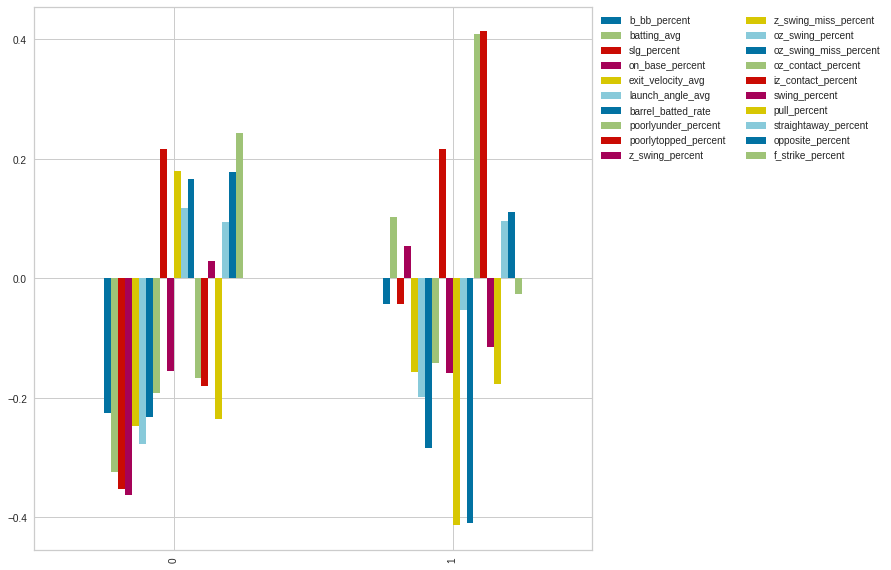

In [ ]:
(pd.DataFrame(pca.components_, columns=X.columns)
.iloc[:2]
 .plot.bar(figsize=(10,10))
 .legend(ncol=(2),bbox_to_anchor=(1,1)))

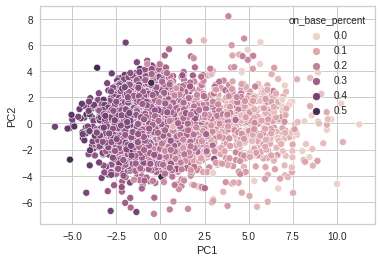

In [ ]:
sns.scatterplot(x='PC1',y='PC2',
                data=pca_X.assign(on_base_percent=X.on_base_percent),
                hue='on_base_percent')

#Clusters
Now we will see how the data comes together in clusters, which in this case should give us something like a profile of a player season. We are going to make 4 clusters and use them as labels to apply to each player season in our data set.

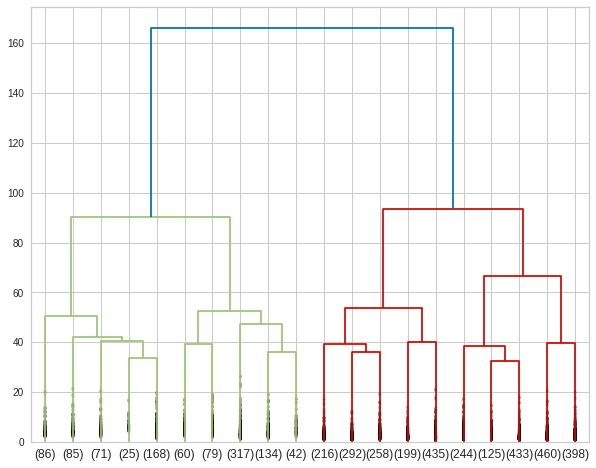

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
hierarchy.dendrogram(hierarchy.linkage(X_std, method='ward'),
                     truncate_mode='lastp', p=20, show_contracted=True)
pass

In [ ]:
agg = cluster.AgglomerativeClustering(n_clusters=4,
                    affinity='euclidean', linkage='ward')
agg.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=4)

In [ ]:
(X.assign(label=agg.labels_)
  .groupby('label')
  .mean()
  .T
  .style.background_gradient(cmap='RdBu',axis=1)
)

label,0,1,2,3
b_bb_percent,7.592597,8.193626,3.073392,6.751534
batting_avg,0.243999,0.213522,0.111219,0.221008
slg_percent,0.384910,0.370019,0.135360,0.320840
on_base_percent,0.305182,0.283138,0.131643,0.273323
exit_velocity_avg,87.220196,88.175805,83.034211,86.689571
launch_angle_avg,12.146489,12.676217,-4.509357,4.353170
barrel_batted_rate,4.706750,7.631666,0.716082,3.525767
poorlyunder_percent,25.744094,25.032214,10.208187,17.261554
poorlytopped_percent,33.766739,32.081426,46.717544,42.628221
z_swing_percent,65.535384,67.296367,55.373099,63.412065


###Label 0: 

Studs: Strongest in the traditional rate stats - batting avg, slugging percent, on base percent - driven by excellent performance in making contact both in and out of the strike zone


###Label 1: 

Sluggers: This label fits the profile of the prototypical modern player - they only swing at strikes (and walk alot) and hit the ball in the air with high exit velocity and pull percent - they are looking to pull the ball over the fence.  



###Label 2: 

Strugglers: These are struggle seasons, with the lowest values for all the things you want to be good at, and the highest values for the things you want to be bad at. Interesting to note these players have the highest first strike percentage - pitchers attack them. 


###Label 3: 

Sticks: This label is like a shadow of Label 0, distinguished by a lower quality of contact. These players make contact and get themselves on base, but they do not smash the ball out of the park.   



In [ ]:
mlb = bb.assign(label=agg.labels_).set_index('last_name')
mlb

#But what does this tell us about old people?
We can now apply these labels to our original data set, which tells us player by player, season by season, who fits into which category. We can then look at the player seasons by age and see how many of each season type we have in every category:

In [ ]:
mlb.pivot_table(columns='player_age',index='label',values='b_ab',aggfunc='count').T

label,0,1,2,3
player_age,,,,
20,2.0,2.0,1.0,2.0
21,11.0,9.0,4.0,5.0
22,33.0,29.0,13.0,15.0
23,67.0,72.0,17.0,26.0
24,118.0,126.0,39.0,35.0
25,161.0,160.0,47.0,54.0
26,198.0,183.0,38.0,43.0
27,178.0,163.0,31.0,59.0
28,175.0,160.0,36.0,42.0


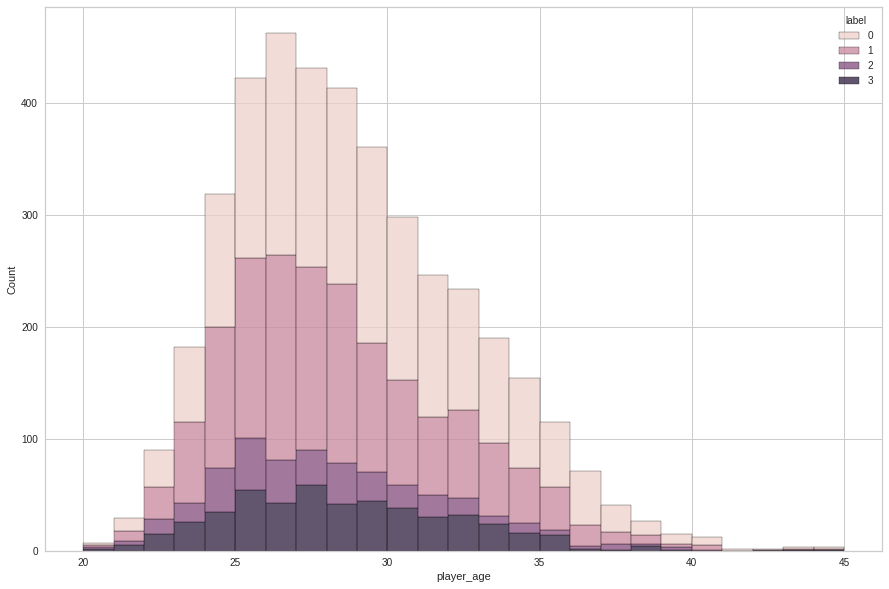

In [ ]:
plt.figure(figsize=(15,10))
sns.histplot(data=mlb,x='player_age',hue='label',bins=25,multiple='stack')

We learned at the start that players can be considered "old" at age 35+ and that exit velocity, launch angle and barrel rate don't drop off until age 40+. The initial analysis suggested that old players can still hit the ball well and my conclusion was they are probably still playing at 35+ because they're so good at hitting the ball. 

Having applied some Machine Learning to this data we generated some clusters and we see that players who make it to 35 and beyond mostly fit into the clusters 0 (studs) and 1 (sluggers). They are high performing hitters, who either excel at making contact, or at generating exit velocity and high launch angles. 

Yes, old people can still barrel the ball in 2020 - because people who barrel the ball get to play for as long as they can.